In [1]:
#!/usr/bin/env python
# encoding: utf-8

In [2]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint
import random
from sklearn.metrics import f1_score
import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
import emoji
# Internal dependencies
import word_emoji2vec as we2v
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed #python -m spacy download en

torch.manual_seed(1)

In [3]:
########## load embeddings #######
loc_emb = torch.load('data/locationEmbeddings.pt') 
#des_emb = torch.load('data/descriptionEmbeddings.pt') 
#twt_emb = torch.load('data/tweetsEmbeddings.pt') 

#load network embedding
#net_emb = gsm.KeyedVectors.load_word2vec_format('data/userNetworkEmd.emd')

In [4]:
#user = net_emb ['000mrs000']
#print(user)
#print(type(net_emb))

In [5]:
#Load 1300 user location, description, yoga tweets, utype, umotivation
df = pd.read_csv("data/yoga_user_name_loc_des_mergetweets_yoga_1300_lb.csv") 
#print (df) #[1308 rows x 7 columns] name, location, description, text, utype, umotivation

In [6]:
##### load train users and split into train and validation #######
with open("data/train.txt", "r") as f:
    data = f.read().split('\n')
random.seed(1)
random.shuffle(data)

train_data = data[:830] #80% train  
#print(train_data, len(train_data)) #830
valid_data = data[830:] #20% validation
#print(valid_data)


In [7]:
########## Create LSTM Model for Location #############
class LSTMLoc(nn.Module):
    def __init__(self):
        super(LSTMLoc, self).__init__()
        self.lstm = nn.LSTM(300, 150, num_layers=1) 
        self.hidden = self.init_hidden() # <- change here 

    def init_hidden(self):
        #(2*self.num_layers, batch_size, self.hidden_dim // 2)# <- change here: first dim of hidden needs to be doubled
        return (torch.zeros(1, 1, 150), torch.zeros(1, 1, 150)) 
    def forward(self, x):
        #x=embeds.permute(1,0,2)
        #print('resize', x.view(len(x),1,-1), x.view(len(x),1,-1).size()) #torch.Size([13, 1, 300])
        #lstm_out, self.hidden = self.lstm(x.view(len(x),1, -1), self.hidden)
        lstm_out, _ = self.lstm(x.view(len(x),1, -1))
        #lstm_out, _ = self.lstm(x.view(len(x),1,-1)) 
        #print('lstm_out', lstm_out, lstm_out.size()) # torch.Size([13, 1, 150])
        #print('self.hidden[0]', self.hidden[0], self.hidden[0].size()) # torch.Size([1, 1, 150])
        #print("lstm_out[-1]", lstm_out[-1], lstm_out[-1].size())  # torch.Size([1, 150])
        #x = self.fc2(lstm_out[-1])  
        #out = F.log_softmax(x, dim = 1)
        #return out
        #return x
        return lstm_out[-1]
    

In [8]:
class Loc(nn.Module):
    def __init__(self):
        super(Loc, self).__init__()
        #self.model_des = BiLSTMDesAtt()
        self.model_loc = LSTMLoc()
        #self.model_net = NetworkMLP()
        self.fc1 = nn.Linear(150, 200) 
        self.fc2 = nn.Linear(200, 3) #if we use two-layer classifier
    def forward(self, x_l): 
        #prediction_des = self.model_des(x_d)
        #print(prediction_des, prediction_des.size()) #torch.Size([1, 3])
        prediction_loc = self.model_loc(x_l)
        #print(prediction_loc, prediction_loc.size()) #torch.Size([1, 3])
        #prediction_net = self.model_net(x_n)
        #print(prediction_net, prediction_net.size()) #torch.Size([1, 3])
        #concat_pred = torch.cat((prediction_des, prediction_loc, prediction_net), 1) #concat with dim= 1
        #concat_pred = torch.cat((prediction_des, prediction_loc), 1) #concat with dim= 1
        #print(concat_pred, concat_pred.size()) #torch.Size([1, 6])
        out = self.fc1(prediction_loc)
        out = self.fc2(F.relu(out))
        out = F.log_softmax(out, dim = 1)
        return out
    

In [9]:
#####prepare data for neural net input #########
def nn_input(train_data,df):
    #ground_truths = []
    #training_data_des =[]
    training_data_loc=[]
    for i in range (0, len(train_data)):
    #for i in range (0, 10):
        for j in range (0,df.shape[0]):
            if (train_data[i] == df.name[j]):
                if (not loc_emb[train_data[i]]):
                    print ('no location for user: ', train_data[i])
                    training_data_loc.append(torch.zeros(1, 300))
                    break
                
                else:
                    sent_tensor_loc = torch.stack(loc_emb[train_data[i]],dim = 1)
                    training_data_loc.append(sent_tensor_loc[-1])
                    break
    return training_data_loc


In [10]:
#####Ground Truth #########
def find_groundtruth(data, df):
    ground_truths = []
    for i in range (0, len(data)):
    #for i in range (0, 10):
        for j in range (0,df.shape[0]):
            if (data[i] == df.name[j]):
                #print(data[i]) #print username
                utype =  [int(df.utype[j])]
                umotivation = [int(float(df.umotivation[j]))]
                target_type = torch.tensor(utype, dtype=torch.long) #for user type
                #target_type = torch.tensor(umotivation, dtype=torch.long) #for user motivation
                ground_truths.append(target_type)
    return ground_truths

In [16]:
###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction_tr(model, training_data_loc, ground_truths):
    predictions =[]
    for i in range (0,len(training_data_loc)):
        prediction_joint = model(training_data_loc[i])
        
        #prediction = model(data[i])
        pred = torch.argmax(prediction_joint, dim=1)
        #print("pred :", pred) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        predictions.append(pred.item())
    #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
    accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_loc)
    macro_f1 = f1_score(ground_truths, predictions, average='macro')
    return accuracy, macro_f1
  

In [17]:
###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction_val(model, training_data_loc, ground_truths):
    predictions =[]
    val_losses = []
    loss_function = nn.NLLLoss()
    for i in range (0,len(training_data_loc)):
        prediction_joint = model(training_data_loc[i])
        val_loss = loss_function(prediction_joint, ground_truths[i])
        val_losses.append(val_loss.item())
        #prediction = model(data[i])
        pred = torch.argmax(prediction_joint, dim=1)
        #print("pred :", pred) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        predictions.append(pred.item())
    #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
    accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_loc)
    macro_f1 = f1_score(ground_truths, predictions, average='macro')
    
    #print(type(predictions), type(ground_truths))
    #print("predictions", predictions)
    #print("ground_truths", ground_truths)
    
    return accuracy, macro_f1, val_losses
  

In [13]:
##########......prepare training and validation data
# ground truth training
train_gt = find_groundtruth(train_data, df)
#####prepare training data for neural net #########
#training_data_net =  nn_input_network(train_data,df)
#print(training_data_net, len(training_data_net)) #ok
training_data_loc =  nn_input(train_data,df)

# ground truth validation
valid_gt = find_groundtruth(valid_data, df)
#####prepare validation data for neural net #########
#validation_data_net =  nn_input_network(valid_data,df)
validation_data_loc =  nn_input(valid_data,df)


no location for user:  Christoph_Tran
no location for user:  yogitimesonline
no location for user:  cipherEquality
no location for user:  thewaywecame


In [18]:
###########.........Start Training...........
model = Loc()
##### Hyperparameter
#learning_rate=0.05
learning_rate=0.01
epochs = 30
#opt="ADAM"
opt="SGD" 
#opt="ADA"
if(opt=="SGD"):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif(opt=="ADA"):
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, eps=1e-06, weight_decay=0.0001)
elif(opt=="ADAM"):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    
loss_function = nn.NLLLoss()
#loss_function = nn.CrossEntropyLoss()

check_val_acc = 0
losses = []
per_epoch_train_loss =[]
per_epoch_val_loss =[]
per_epoch_train_f1 =[]
per_epoch_val_f1 = []
for epoch in range(epochs): 
    print('*************** Starting with epoch: ', epoch, '***********************')
    for i in range (0,len(train_data)):
        #model_des.zero_grad()
        #model_loc.zero_grad()
        model.zero_grad()
        #####Run forward pass.
      
        prediction_joint = model(training_data_loc[i])
        
        #print("prediction_joint :", torch.argmax(prediction_joint, dim=1)) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        #Compute the loss, gradients, and update the parameters by
        #calling optimizer.step()
        loss = loss_function(prediction_joint, train_gt[i])
        #if (i%200 == 0):
            #print ("loss per example", loss.item())
        losses.append(loss.item())
        loss.backward(retain_graph=True)  #backpropagation
        optimizer.step()
    accuracy, macro_f1 = make_prediction_tr(model, training_data_loc, train_gt)
    print('epoch :', epoch, 'Train accuracy and macro_f1:', accuracy, macro_f1)
    per_epoch_train_f1.append(macro_f1)
    val_accuracy, val_macro_f1, val_loss = make_prediction_val(model, validation_data_loc, valid_gt)
    per_epoch_val_f1.append(val_macro_f1)
    print('epoch :', epoch, 'Validation accuracy, macro_f1:', val_accuracy, val_macro_f1)
    per_epoch_train_loss.append(np.mean(losses))
    print("train loss per epoch", np.mean(losses))
    per_epoch_val_loss.append(np.mean(val_loss))
    print('Validation loss per epoch:', np.mean(val_loss))
    
    torch.save(model.state_dict(),"data/Loc_utype_2layer/loc_"+str(epoch)+".pt")
#     if (check_val_acc < val_macro_f1): #early stopping
#         check_val_acc = val_macro_f1
#         print ("Model saved at epoch :", epoch)
#         torch.save(model.state_dict(),"data/joint_DLT.pt")
#         best_epoch = epoch
        
#print("Best model found at epoch : ", best_epoch)        
#torch.save(model.state_dict(),"data/joint_DLT.pt")
    

*************** Starting with epoch:  0 ***********************


/Users/tunaz/miniconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch : 0 Train accuracy and macro_f1: 0.5903614457831325 0.4457857264824012
epoch : 0 Validation accuracy, macro_f1: 0.616504854368932 0.4531366157717161
train loss per epoch 1.0201243936297406
Validation loss per epoch: 0.9256615071620756
*************** Starting with epoch:  1 ***********************
epoch : 1 Train accuracy and macro_f1: 0.6012048192771084 0.45712418378189273
epoch : 1 Validation accuracy, macro_f1: 0.6067961165048543 0.4460066953610713
train loss per epoch 0.9902166091893093
Validation loss per epoch: 0.9161943715174221
*************** Starting with epoch:  2 ***********************
epoch : 2 Train accuracy and macro_f1: 0.6168674698795181 0.47195762559059345
epoch : 2 Validation accuracy, macro_f1: 0.6019417475728155 0.4423890771911683
train loss per epoch 0.9745938807606218
Validation loss per epoch: 0.914989276997094
*************** Starting with epoch:  3 ***********************
epoch : 3 Train accuracy and macro_f1: 0.6240963855421687 0.5039518518350895
epoch

epoch : 27 Train accuracy and macro_f1: 0.7506024096385542 0.7240503767597982
epoch : 27 Validation accuracy, macro_f1: 0.5194174757281553 0.4704642942932638
train loss per epoch 0.7798358900052546
Validation loss per epoch: 2.6217527218814034
*************** Starting with epoch:  28 ***********************
epoch : 28 Train accuracy and macro_f1: 0.7289156626506024 0.7079504409847046
epoch : 28 Validation accuracy, macro_f1: 0.49029126213592233 0.4357701842775703
train loss per epoch 0.7751810270793021
Validation loss per epoch: 1.9627171262954046
*************** Starting with epoch:  29 ***********************
epoch : 29 Train accuracy and macro_f1: 0.7626506024096386 0.739657639974947
epoch : 29 Validation accuracy, macro_f1: 0.5097087378640777 0.4382216188581219
train loss per epoch 0.7693150194390231
Validation loss per epoch: 2.159186241696182


<Figure size 432x288 with 0 Axes>

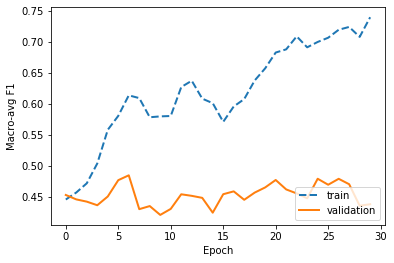

In [19]:
def save_plots(train_losses, val_losses, train_accs, test_accs):
    """Plot

        Plot two figures: loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_losses)
    xs = np.arange(n)

    # plot losses
    fig, ax = plt.subplots()
    ax.plot(xs, train_losses, '--', linewidth=2, label='train loss')
    ax.plot(xs, val_losses, '-', linewidth=2, label='validation loss')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right')
    plt.savefig('loss_Loc_utype.png')

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_accs, '--', linewidth=2, label='train')
    ax.plot(xs, test_accs, '-', linewidth=2, label='validation')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Macro-avg F1")
    ax.legend(loc='lower right')
    plt.savefig('accuracy_Loc_utype.png')
    
save_plots(per_epoch_train_loss, per_epoch_val_loss, per_epoch_train_f1, per_epoch_val_f1)
# print(per_epoch_train_loss)
# print(per_epoch_val_loss)

In [20]:

###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction(training_data_loc, ground_truths):
    for epoch in range(0,30):
        model = Loc()
        model.load_state_dict(torch.load("data/Loc_utype_2layer/loc_"+str(epoch)+".pt")) 
        predictions =[]
        for i in range (0,len(training_data_loc)):
            prediction_joint = model(training_data_loc[i])
            pred = torch.argmax(prediction_joint, dim=1)
            predictions.append(pred.item())
        #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
        accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_loc)
        macro_f1 = f1_score(ground_truths, predictions, average='macro')
        print('epoch :', epoch, 'Testing accuracy, macro_f1:', accuracy, macro_f1)
        #return accuracy, macro_f1

In [21]:
########.....Load Test data.......
with open("data/test.txt", "r") as f:
    data = f.read().split('\n')
test_data = data[:] 
#print(test_data, len(test_data)) #262

In [22]:
#####prepare testing data for neural net #########
testing_data_loc =  nn_input(test_data,df)
#testing_data_net =  nn_input_network(test_data,df)
test_gt = find_groundtruth(test_data, df)

no location for user:  vaibhavatttc


In [23]:
make_prediction(testing_data_loc, test_gt)

epoch : 0 Testing accuracy, macro_f1: 0.648854961832061 0.4620565422919822
epoch : 1 Testing accuracy, macro_f1: 0.6564885496183206 0.468191025508978
epoch : 2 Testing accuracy, macro_f1: 0.6679389312977099 0.47623956293165653
epoch : 3 Testing accuracy, macro_f1: 0.6679389312977099 0.4913954102087838
epoch : 4 Testing accuracy, macro_f1: 0.6755725190839694 0.5457926831582103
epoch : 5 Testing accuracy, macro_f1: 0.6526717557251909 0.5407102963401011
epoch : 6 Testing accuracy, macro_f1: 0.6259541984732825 0.5431398115250305
epoch : 7 Testing accuracy, macro_f1: 0.6374045801526718 0.539047969155496
epoch : 8 Testing accuracy, macro_f1: 0.6755725190839694 0.5627133938152374
epoch : 9 Testing accuracy, macro_f1: 0.6755725190839694 0.544049190491905
epoch : 10 Testing accuracy, macro_f1: 0.6717557251908397 0.5191682910981156
epoch : 11 Testing accuracy, macro_f1: 0.6679389312977099 0.5617261982805447
epoch : 12 Testing accuracy, macro_f1: 0.6564885496183206 0.5453321586447804
epoch : 13 T